# Polynomial interpolation

In this notebook we try to replace functions with a (finite-dimensional) polynomial approximation. Several different polynomials basis are implemented.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

First of all we define our basis, and a convenient function to recover a particular basis:

In [4]:
def monomials(i):
    return lambda x: np.power(x,i)

def lagrange(j, interpolation_points):
    return lambda x: np.product(
            [(x - interpolation_points[i]) / (interpolation_points[j] - interpolation_points[i]) 
                 for i in np.delete(np.array(range(len(interpolation_points))), j)], 
            axis=0)

def generate_basis(label, interpolation_points):
    if label[0] == 'l':
        return [lagrange(i, interpolation_points) for i in range(len(interpolation_points))]
    elif label[0] == 'm':
        return [monomials(i) for i in range(len(interpolation_points))]

We plot the basis to show how they work:

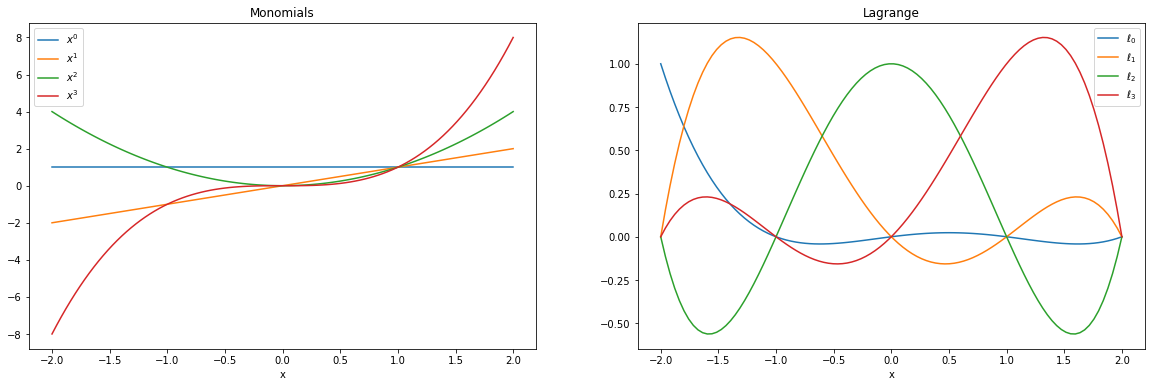

In [5]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
x = np.linspace(-2,2,100)
for i in range(4):
    plt.plot(x,monomials(i)(x), label='$x^{}$'.format(i))
plt.legend()
plt.title('Monomials')
plt.xlabel('x')

interp_points = np.linspace(-2,2,5)

plt.subplot(1,2,2)
x = np.linspace(-2,2,100)
for i in range(4):
    plt.plot(x,lagrange(i, interp_points)(x), label='$\\ell_{}$'.format(i))
plt.legend()
plt.title('Lagrange')
plt.xlabel('x')

plt.show()

Then, we create several functions to perform the actual interpolation:

In [13]:
def V_matrix(interpolation_points, basis):
    return np.array([f(interpolation_points) for f in basis]).T

# interpolation entry-point
# l -> 'lagrange'
def interpolate(f, interpolation_points, basis_label='l'):
    basis = generate_basis(basis_label, interpolation_points)
    
    V = V_matrix(interpolation_points, basis)
    p = np.linalg.solve(V, f(interpolation_points))
    
    return lambda x: np.inner(p, np.array([bf(x) for bf in basis]).T)

In order to check the correctness of our implementation, we visualize the columns of the matrix $V$: 
+ In the Lagrangian basis, the $j$-th one should be $\ell_j$ evaluated in the control points, namely it should evaluate to 1 in only one point, and 0 in all the others;
+ In the monomial basis each column should look like a monomial evaluated in the control points.

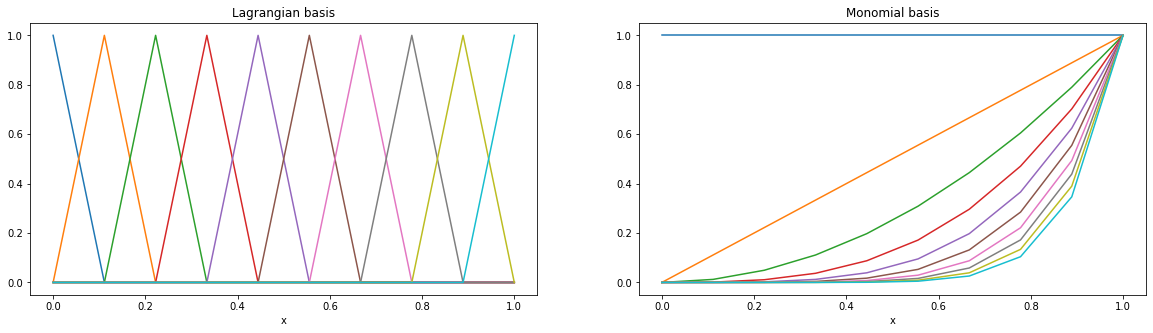

In [15]:
interp_points = np.linspace(0,1,10)

plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
V = V_matrix(interp_points, generate_basis('l', interp_points))

plt.title('Lagrangian basis')
plt.xlabel('x')
for j in range(V.shape[1]):
    plt.plot(interp_points, V[:,j])

plt.subplot(1,2,2)
V = V_matrix(interp_points, generate_basis('m', interp_points))

plt.title('Monomial basis')
plt.xlabel('x')
for j in range(V.shape[1]):
    plt.plot(interp_points, V[:,j])
    
plt.show()

We now test our functions on $\sin$, using two different basis:

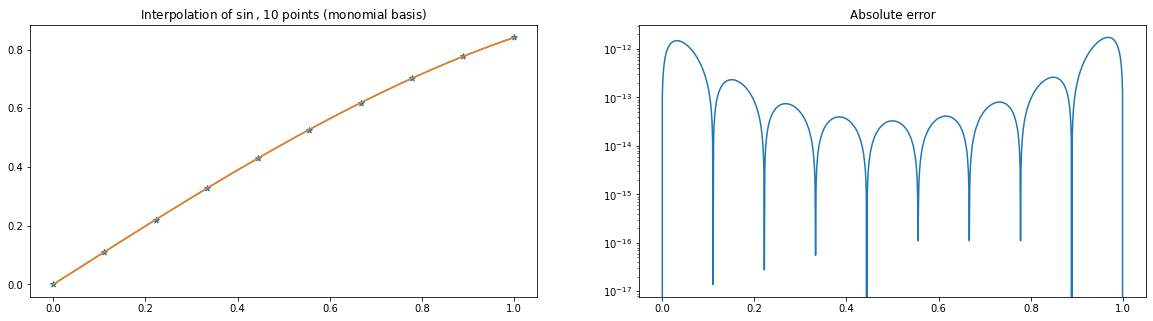

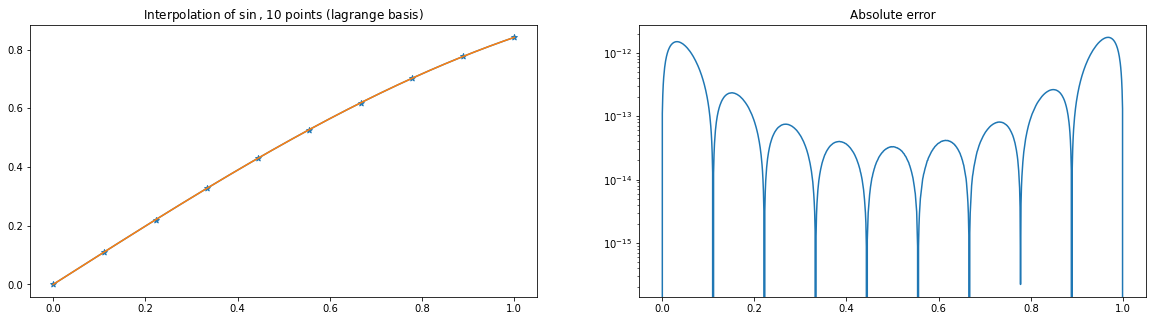

In [16]:
interp_points = np.linspace(0,1,10)
x = np.linspace(0,1,1000)

labels = ['monomial', 'lagrange']

for l in labels:
    fintp = interpolate(np.sin, interp_points, basis_label=l)

    plt.figure(figsize=(20,5))

    plt.subplot(1,2,1)
    plt.plot(x, np.sin(x))
    plt.plot(x, fintp(x))
    plt.scatter(interp_points, np.sin(interp_points), marker='*')
    plt.title('Interpolation of $\sin$, {} points ({} basis)'.format(len(interp_points), l))

    plt.subplot(1,2,2)
    plt.plot(x, np.abs(fintp(x) - np.sin(x)))
    plt.title('Absolute error'.format(len(interp_points)))
    plt.yscale('log')

    plt.show()

We now evaluate the behavior of $\Vert f - I^nf \Vert_\infty$ for varying $n$, where $I^n$ is the interpolation operator we defined in the functions above.

In [94]:
def chebyshev(n, a=-1, b=1):
    return 0.5*(a+b) + 0.5*(b-a)*np.cos((2*np.arange(1,n+1)-1) / (2*n) * np.pi)

def linfty(f):
    return np.max(np.abs(f))

def convergency_plot(f, a, b, interp_points='l'):
    if interp_points == 'l':
        interp_points = lambda ni: np.linspace(a,b,ni)
    elif interp_points == 'c':
        interp_points = lambda ni: chebyshev(ni, a, b)
    else:
        raise ValueError('Invalid interpolation points label')
    
    n = range(5,51,5)
    x = np.linspace(a,b,1000)

    labels = ['Monomials', 'Lagrange']

    plt.figure(figsize=(20,5))

    for l in labels:
        bl=l[0].lower()
        ip_error = lambda interp_points: linfty(
            interpolate(f, interp_points, basis_label=bl)(x) - f(x)
        )
        
        plt.plot(n, list(map(ip_error, map(interp_points, n))), label=l)
        
    plt.yscale('log')
    plt.legend()
    plt.title('$\Vert f - \\mathcal{I}^nf \Vert_\infty$', fontsize=20)
    plt.xlabel('n. of interpolation points')

    plt.show()

For $\sin$ on $[\pi, 2\pi]$:

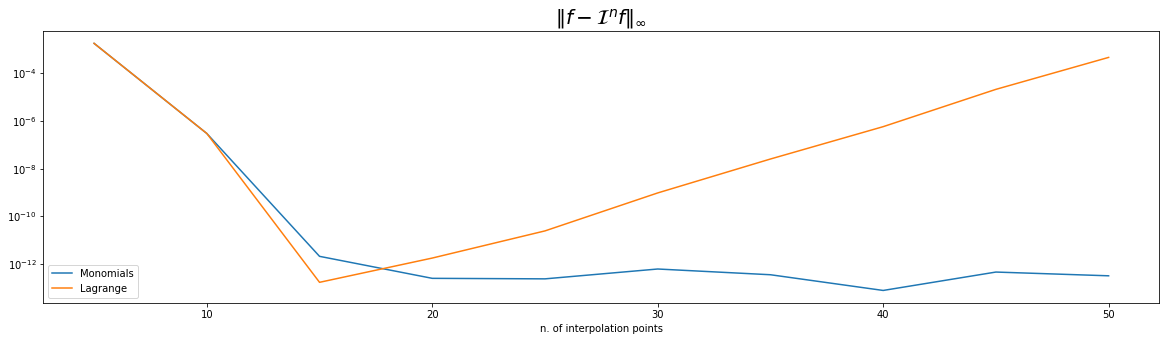

In [95]:
convergency_plot(np.sin, np.pi, 2*np.pi)

And for the more problematic case of $|x|$ on $[-1,1]$:

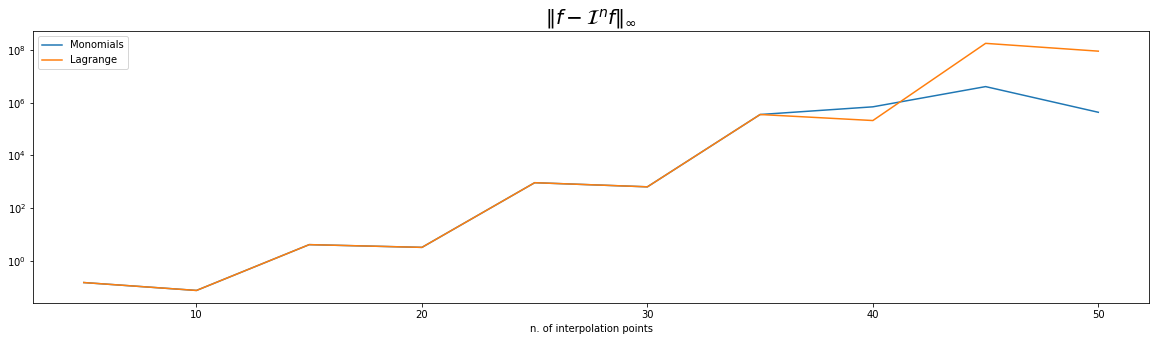

In [96]:
convergency_plot(np.abs, -1,1)

The latter graph is quite astonishing, but keep in mind that the $\Vert \cdot \Vert_\infty$ error comes most likely from the extremal part of the interpolated interval, as you can see here:

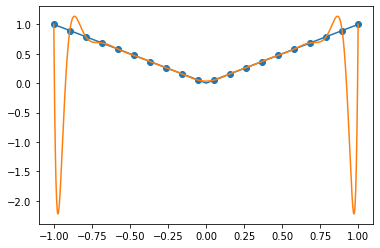

In [97]:
x = np.linspace(-1,1,1000)
interp_points = np.linspace(-1,1,20)
f = np.abs

plt.plot(x, f(x))
plt.plot(x, interpolate(f, interp_points, basis_label='l')(x))
plt.scatter(interp_points, f(interp_points), marker='o');

We now try to experiment a little bit with Chebyshev nodes. The key idea is to have nodes more concentrated as we approach the extremes of the interval. This helps us to keep under control the feared _Runge effect_. As we can see, the situation is much better:

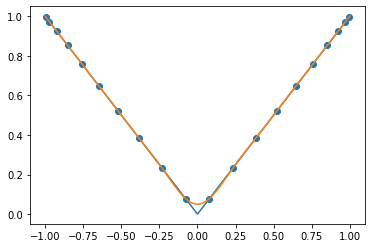

In [91]:
interp_points = chebyshev(20)

plt.plot(x, f(x))
plt.plot(x, interpolate(f, interp_points, basis_label='l')(x))
plt.scatter(interp_points, f(interp_points), marker='o');

What about our convergency plot?

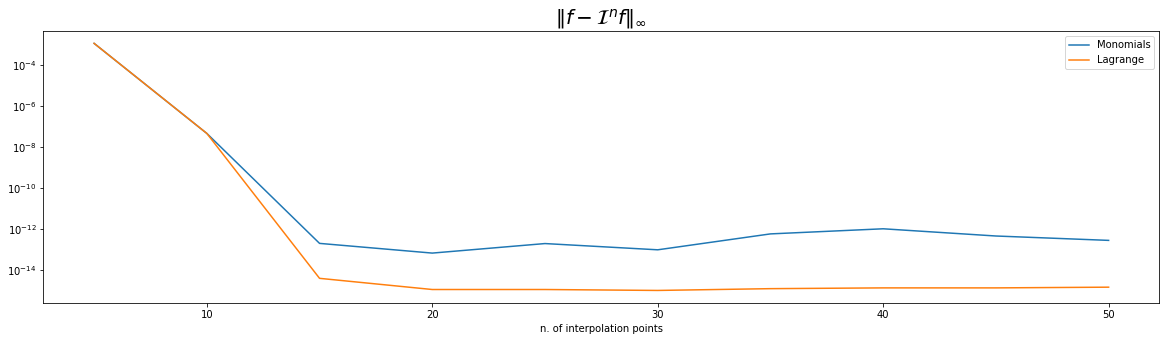

In [98]:
convergency_plot(np.sin, np.pi, 2*np.pi, 'c')

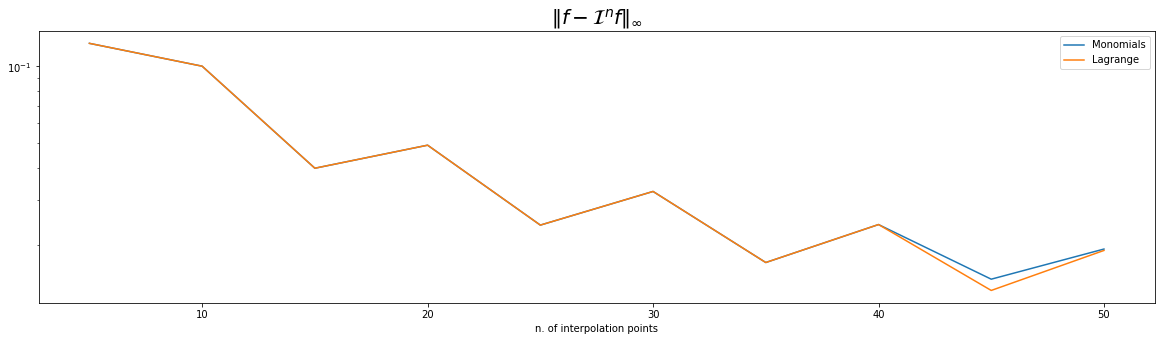

In [99]:
convergency_plot(np.abs, -1,1, 'c')